**Описание проекта**
 
Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

## Загрузка данных

In [1]:
!pip install phik

In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
# Импортируем нужные для работы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import scipy.stats as stats

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats as st


In [4]:
# Загружаем данные в датафрейм pandas 

# загружаем ferma_main.csv как fm_df
fm_df = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')

# загружаем ferma_dad.csv как dad_df
dad_df = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')

# загружаем cow_buy.csv как cow_df
cow_df = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

In [5]:
fm_df.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [6]:
dad_df.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [7]:
cow_df.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


##  Предобработка данных

In [8]:
# Проверяем на пропущенные значения датафрейм 
fm_df.isna().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

In [9]:
# Проверяем на пропущенные значения датафрейм 
dad_df.isna().sum()

id          0
Имя Папы    0
dtype: int64

In [10]:
# Проверяем на пропущенные значения датафрейм 
cow_df.isna().sum()

Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

По выведенным выше данным, пропущенных или пустых значений во всех полученных датафреймах не имеются

In [11]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Необходимо изменить названия столбцов `fm_df` на корректные названия и нижний регистр

In [12]:
# Меняем названия столбцов датарфейма ferma_main на 
# корректные и переводим на нижний регистр
fm_df = fm_df.rename(columns={"Удой, кг": "milk_yield_kg", "ЭКЕ (Энергетическая кормовая единица)": \
                              "feu", "Сырой протеин, г": "crude_protein_g", "СПО (Сахаро-протеиновое соотношение)": "spo", \
                             "Порода": "breed", "Тип пастбища": "grazing_type", "порода папы_быка": "father_breed", \
                              "Жирность,%": "milk_fat_%", "Белок,%": "milk_protein_%", "Вкус молока": "milk_taste", \
                              "Возраст": "age_of_cow"})

fm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   milk_yield_kg    634 non-null    int64  
 2   feu              634 non-null    float64
 3   crude_protein_g  634 non-null    int64  
 4   spo              634 non-null    float64
 5   breed            634 non-null    object 
 6   grazing_type     634 non-null    object 
 7   father_breed     634 non-null    object 
 8   milk_fat_%       634 non-null    float64
 9   milk_protein_%   634 non-null    float64
 10  milk_taste       634 non-null    object 
 11  age_of_cow       634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


После выше проведенных изменений в датафрейма имеются следующие столбцы:

- `id`: уникальный идентификатор животного
- `milk_yield_kg`: количество молока в килограммах, произведенное животным
- `feu`: энергетическая кормовая единица
- `crude_protein_g`: содержание сырого протеина в граммах
- `spo`: сахаро-протеиновое соотношение
- `breed`: порода животного
- `grazing_type`: тип пастбища
- `father_breed`: порода отца (быка)
- `milk_fat_%`: содержание жира в молоке в процентах
- `milk_protein_%`: содержание белка в молоке в процентах
- `milk_taste`: оценка вкуса молока
- `age_of_cow`: возраст коровы

In [13]:
# Создание словаря с именами столбцов и желаемыми типами данных
fm_df_dtype_dict = {'milk_fat_%': float, 'milk_protein_%': float, 'feu': float,'spo': float}

# Преобразование типов данных столбцов с помощью метода astype()
fm_df = fm_df.astype(fm_df_dtype_dict)

fm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   milk_yield_kg    634 non-null    int64  
 2   feu              634 non-null    float64
 3   crude_protein_g  634 non-null    int64  
 4   spo              634 non-null    float64
 5   breed            634 non-null    object 
 6   grazing_type     634 non-null    object 
 7   father_breed     634 non-null    object 
 8   milk_fat_%       634 non-null    float64
 9   milk_protein_%   634 non-null    float64
 10  milk_taste       634 non-null    object 
 11  age_of_cow       634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Были изменены типы данных датафрейма `fm_df` на `float` в следующих столбцах:

- `milk_fat_%` 
- `milk_protein_%` 
- `feu` 
- `spo`

In [14]:
fm_df.head()

,id,milk_yield_kg,feu,crude_protein_g,spo,breed,grazing_type,father_breed,milk_fat_%,milk_protein_%,milk_taste,age_of_cow
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [15]:
# Проверяем на наличие дубликатов в датафрейме
duplicated_fm_df = fm_df[fm_df['id'].duplicated()]
display(duplicated_fm_df)

# Выводим количество уникальных значений из датафрейма
fm_df.nunique()

,id,milk_yield_kg,feu,crude_protein_g,spo,breed,grazing_type,father_breed,milk_fat_%,milk_protein_%,milk_taste,age_of_cow
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


id                 629
milk_yield_kg      528
feu                 55
crude_protein_g    401
spo                 12
breed                2
grazing_type         3
father_breed         3
milk_fat_%          50
milk_protein_%      15
milk_taste           2
age_of_cow           2
dtype: int64

In [16]:
# Выводим размер датафрейма
fm_df.shape[0]

634

In [17]:
# Удаляем явные дубликаты из датафрейма
fm_df.drop_duplicates(inplace=True)

fm_df[fm_df.duplicated()]

,id,milk_yield_kg,feu,crude_protein_g,spo,breed,grazing_type,father_breed,milk_fat_%,milk_protein_%,milk_taste,age_of_cow


In [18]:
1 - fm_df.shape[0]/634

0.007886435331230235

Удаленные строки из датафрейма `fm_df` составил ≈ `0.79%` из всего датафрейма

In [19]:
dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [20]:
# Меняем название столбца "Имя Папы" датафрейма dad_df
dad_df = dad_df.rename(columns={'Имя Папы': 'father_name'})

dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   father_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [21]:
cow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [22]:
# Меняем названия столбцов датарфейма cow_df на 
# корректные и переводим на нижний регистр
cow_df = cow_df.rename(columns={"Порода": "cow_breed", "Тип пастбища": "grazing_type", \
                               "порода папы_быка": "father_breed", "Имя_папы": "father_name", \
                               "Текущая_жирность,%": "curr_milk_fat_%", \
                                "Текущий_уровень_белок,%": "curr_protein_%", \
                                "Возраст": "age_of_cow"})

cow_df.head()

,cow_breed,grazing_type,father_breed,father_name,curr_milk_fat_%,curr_protein_%,age_of_cow
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


После выше проведенных изменений в датафрейма имеются следующие столбцы:

- `cow_breed` - порода бурёнка,
- `grazing_type` - тип пастбища,
- `father_breed` - порода отца (быка),
- `father_name` - Имя папы,
- `curr_milk_fat_%` - текущее содержание жира в молоке в процентах,
- `curr_protein_%` - текущее содержание белка в молоке в процентах,
- `age_of_cow` - возраст коровы.


In [23]:
# Создание словаря с именами столбцов и желаемыми типами данных
cow_df_dtype_dict = {'curr_milk_fat_%': float, 'curr_protein_%': float}

# Преобразование типов данных столбцов с помощью метода astype()
cow_df = cow_df.astype(cow_df_dtype_dict)

cow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cow_breed        20 non-null     object 
 1   grazing_type     20 non-null     object 
 2   father_breed     20 non-null     object 
 3   father_name      20 non-null     object 
 4   curr_milk_fat_%  20 non-null     float64
 5   curr_protein_%   20 non-null     float64
 6   age_of_cow       20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Были изменены типы данных датафрейма `cow_df` на `float` в следующих столбцах:

- `curr_milk_fat_%`;
- `curr_protein_%` 

In [24]:
duplicated_cow_df = cow_df[cow_df.duplicated()]
display(duplicated_cow_df)

cow_df.nunique()

,cow_breed,grazing_type,father_breed,father_name,curr_milk_fat_%,curr_protein_%,age_of_cow
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


cow_breed           2
grazing_type        2
father_breed        2
father_name         4
curr_milk_fat_%    12
curr_protein_%     12
age_of_cow          2
dtype: int64

**Описание исходных данных:**

1. Исходные данные файла /datasets/ferma_main.csv (fm_df) представляет собой набор информации о коровах, их уникальных ID номерах, их удойности в кг и их породах, о показателях питательности корма коровы (ЭКЕ), содеражния сырого протеина в корме в граммах, отношении сахара к протеину в корме коровы (СПО), типа пастбищ, где они паслись, породах отцов-быков, жирности молока в процентах, белок молока в процентах, вкусе молока и о возрасте самой коровы.

2. Исходные данные файла /datasets/ferma_dad.csv (dad_df) представляет собой набор информации об уникальных ID номерах и именах отцов-быков коров

3. Исходные данные файла /datasets/cow_buy.csv (cow_df) представляет собой набор информации о породе коров, типа пастбищ, где они паслись, породы и имени отца-быка коров, текущего содержания жира в молоке в процентах, текущего содержания уровня белка в молоке в процентах и о возрасте самой коровы.

**Качество данных**

Исходные данные нуждались в предобработке перед их анализом. Были обнаружены дублированные данные, нет явных признаков некорректных данных.

1. В датафрейме `fm_df` были изменены названия следующих столбцов:

- `id`: уникальный идентификатор животного
- `milk_yield_kg`: количество молока в килограммах, произведенное животным
- `feu`: энергетическая кормовая единица
- `crude_protein_g`: содержание сырого протеина в граммах
- `spo`: сахаро-протеиновое соотношение
- `breed`: порода животного
- `grazing_type`: тип пастбища
- `father_breed`: порода отца (быка)
- `milk_fat_%`: содержание жира в молоке в процентах
- `milk_protein_%`: содержание белка в молоке в процентах
- `milk_taste`: оценка вкуса молока
- `age_of_cow`: возраст коровы

2. Были изменены типы данных датафрейма `fm_df` на `float` в следующих столбцах:

- `milk_fat_%` 
- `milk_protein_%` 
- `feu` 
- `spo`

3. Явные дубликаты датафрейма `fm_df` были удалены. Процентное соотношение удаленных строк из датафрейма составило ≈ `0.79%` из всего датафрейма

4. Название столбца датафрейма `dad_df` было изменено на следующее `Имя Папы` - `father_name`

5. Названия столбцов датафрейма `cow_df` были изменены на следующие:

- `cow_breed` - порода бурёнка,
- `grazing_type` - тип пастбища,
- `father_breed` - порода отца (быка),
- `father_name` - Имя папы,
- `curr_milk_fat_%` - текущее содержание жира в молоке в процентах,
- `curr_protein_%` - текущее содержание белка в молоке в процентах,
- `age_of_cow` - возраст коровы.

6. Были изменены типы данных датафрейма `cow_df` на `float` в следующих столбцах:

- `curr_milk_fat_%`;
- `curr_protein_%` 

## Исследовательский анализ данных

In [25]:
fm_df.describe()

,id,milk_yield_kg,feu,crude_protein_g,spo,milk_fat_%,milk_protein_%
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


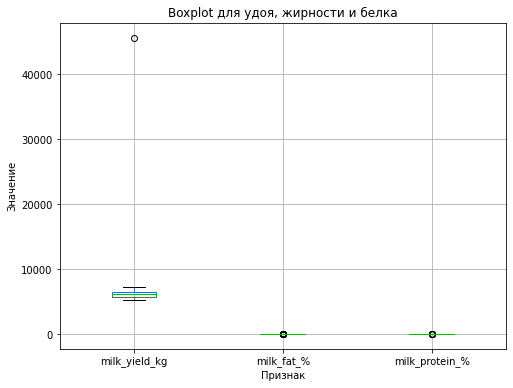

In [26]:
# Создание нового графика с заданным размером
plt.figure(figsize=(8, 6))
fm_df[['milk_yield_kg', 'milk_fat_%', 'milk_protein_%']].boxplot()
plt.title('Boxplot для удоя, жирности и белка')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.grid(True)
plt.show()


Как видно на графике, наблюдается выброс в значениях столбца `milk_yield_kg`

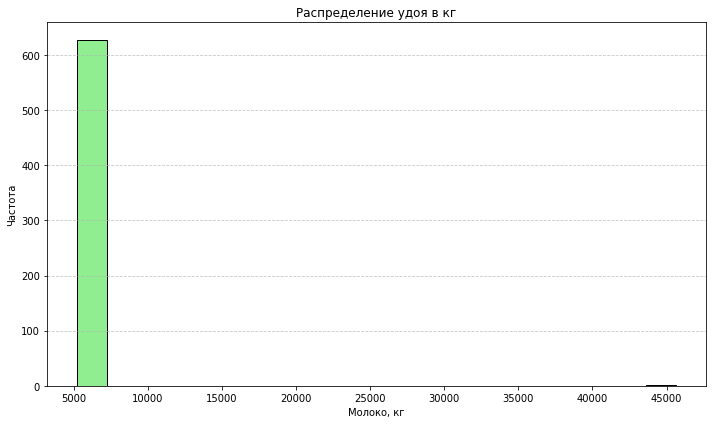

In [27]:
# Строим график распределения удоя в кг
# limited_milk_yield = fm_df.query("milk_yield_kg < 40000")
plt.figure(figsize=(10, 6))
plt.hist(fm_df['milk_yield_kg'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Распределение удоя в кг')
plt.xlabel('Молоко, кг')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:

fm_df.shape[0]

629

In [29]:
fm_df.drop(fm_df[fm_df['milk_yield_kg'] >= 40000].index, inplace=True)

In [30]:
fm_df.shape[0]

628

При выполнении условия, где выбираются значения столбца `milk_yield_kg` без выбросов, можно потерять всего-лишь одну запись из целового датафрейма

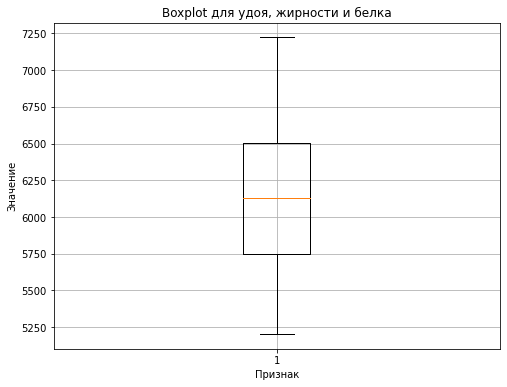

In [31]:
# Создание нового графика с заданным размером
plt.figure(figsize=(8, 6))
plt.boxplot(fm_df['milk_yield_kg'])
plt.title('Boxplot для удоя, жирности и белка')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.grid(True)
plt.show()


После "удаления" не нужных строк из датафрейма, выборосов больше не наблюдается 

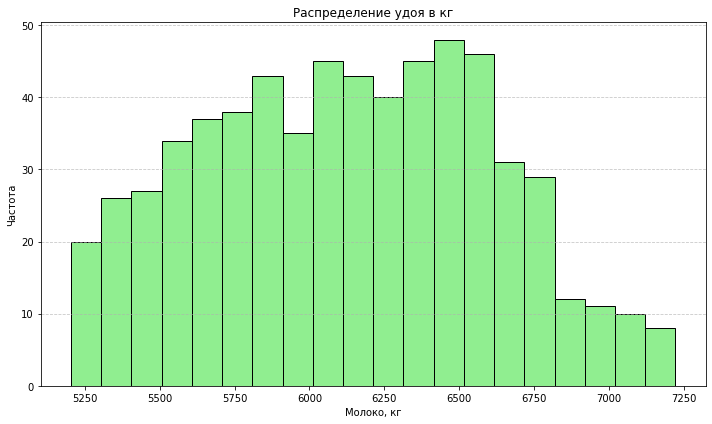

In [32]:
# Визуализация распределения расстояния поездок
plt.figure(figsize=(10, 6))
plt.hist(fm_df['milk_yield_kg'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Распределение удоя в кг')
plt.xlabel('Молоко, кг')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

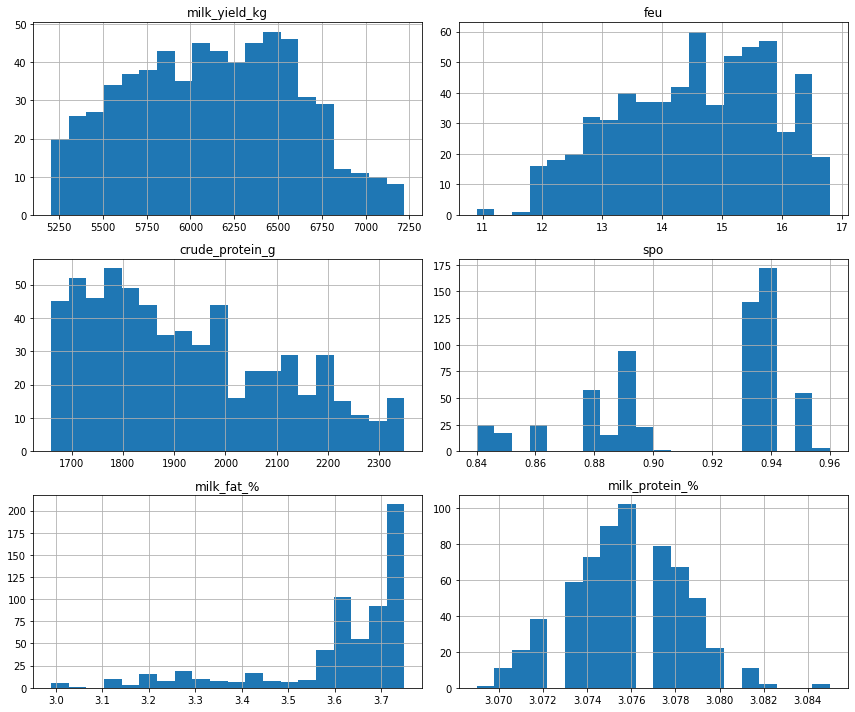

,milk_yield_kg,feu,crude_protein_g,spo,milk_fat_%,milk_protein_%
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [33]:
fm_df_without_id = fm_df.drop(columns=['id'])


fm_df_without_id.hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

fm_df_without_id.describe()

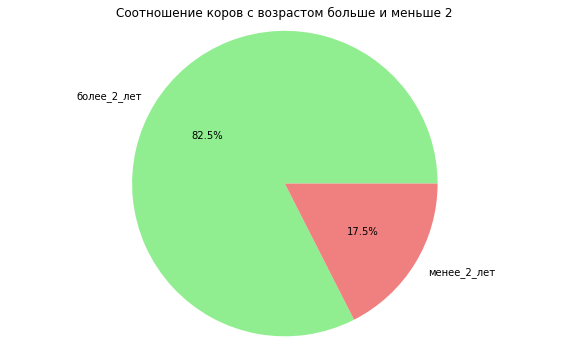

In [34]:
# Подсчет соотношения возраста бурёнки, более 2 лет или менее
age_of_cows_counts = fm_df['age_of_cow'].value_counts()

# Визуализация соотношения бурёнки
plt.figure(figsize=(8, 5))
age_of_cows_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Соотношение коров с возрастом больше и меньше 2')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()


Соотношение возраста коров в датафрейме `fm_df` составляет `82.5%` (более2 лет) на `17.5%` (менее 2 лет)

In [35]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               628 non-null    int64  
 1   milk_yield_kg    628 non-null    int64  
 2   feu              628 non-null    float64
 3   crude_protein_g  628 non-null    int64  
 4   spo              628 non-null    float64
 5   breed            628 non-null    object 
 6   grazing_type     628 non-null    object 
 7   father_breed     628 non-null    object 
 8   milk_fat_%       628 non-null    float64
 9   milk_protein_%   628 non-null    float64
 10  milk_taste       628 non-null    object 
 11  age_of_cow       628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


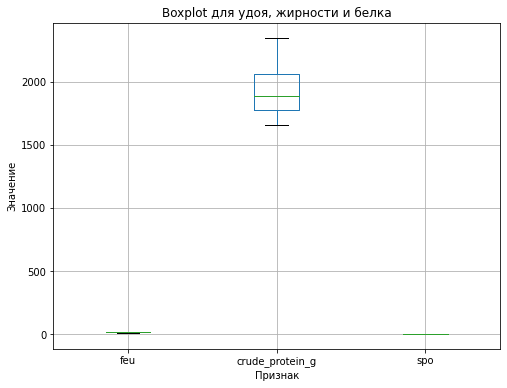

In [36]:
# Создание нового графика с заданным размером
plt.figure(figsize=(8, 6))
fm_df[['feu', 'crude_protein_g', 'spo']].boxplot()
plt.title('Boxplot для удоя, жирности и белка')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.grid(True)
plt.show()


In [37]:
fm_df['crude_protein_g'].describe()

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: crude_protein_g, dtype: float64

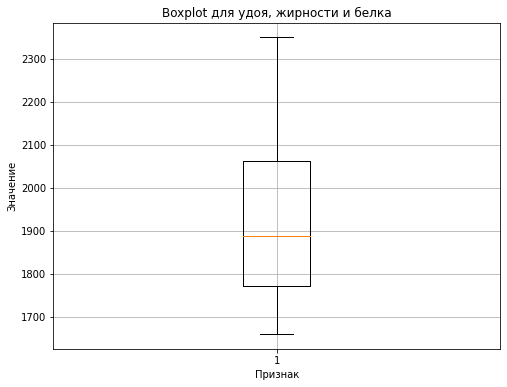

In [38]:
plt.figure(figsize=(8, 6))
plt.boxplot(fm_df['crude_protein_g'])
plt.title('Boxplot для удоя, жирности и белка')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.grid(True)
plt.show()

In [39]:
dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   father_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Так как в датафрейме `dad_df` имеются данные только об именах отцов-быков коров, не будем строить графики

In [40]:
cow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cow_breed        20 non-null     object 
 1   grazing_type     20 non-null     object 
 2   father_breed     20 non-null     object 
 3   father_name      20 non-null     object 
 4   curr_milk_fat_%  20 non-null     float64
 5   curr_protein_%   20 non-null     float64
 6   age_of_cow       20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


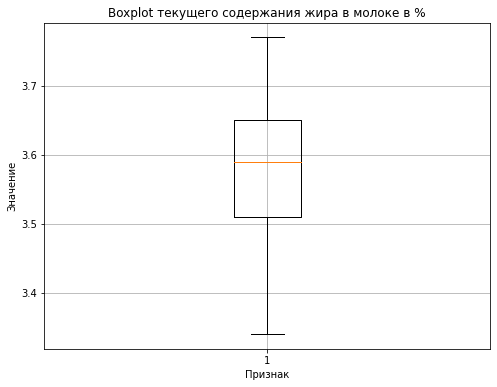

In [41]:
plt.figure(figsize=(8, 6))
plt.boxplot(cow_df['curr_milk_fat_%'])
plt.title('Boxplot текущего содержания жира в молоке в %')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.grid(True)
plt.show()

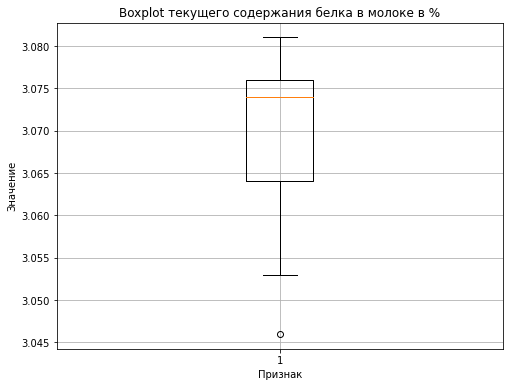

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: curr_protein_%, dtype: float64

In [42]:
plt.figure(figsize=(8, 6))
plt.boxplot(cow_df['curr_protein_%'])
plt.title('Boxplot текущего содержания белка в молоке в %')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.grid(True)
plt.show()

cow_df['curr_protein_%'].describe()

In [43]:
# Вычисляем значение 25-го квартиля для столбца
q25 = cow_df['curr_protein_%'].quantile(0.25)

# Подсчитываем количество значений в столбце, которые меньше q25
count_values_below_q25 = (cow_df['curr_protein_%'] < q25).sum()

print("Количество значений, меньших 25-го квартиля:", count_values_below_q25)
print("Значение 25 квартиля: ", q25)

Количество значений, меньших 25-го квартиля: 5
Значение 25 квартиля:  3.064


In [44]:
cow_df.shape[0]

20

В столбце `curr_protein_%` датафрейма `cow_df` наблюдаются выбросы:

- Количество значений, меньших 25-го квартиля: 5

Количество самих значений в датафрейма составляет `20` строк данных. По этой причине удаление выбросов не будет произведен



In [45]:
cow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cow_breed        20 non-null     object 
 1   grazing_type     20 non-null     object 
 2   father_breed     20 non-null     object 
 3   father_name      20 non-null     object 
 4   curr_milk_fat_%  20 non-null     float64
 5   curr_protein_%   20 non-null     float64
 6   age_of_cow       20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


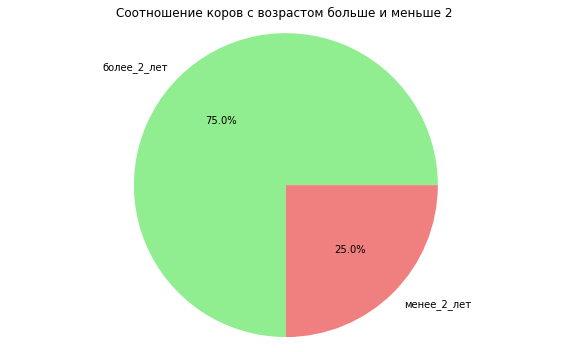

In [46]:
# Подсчет соотношения возраста бурёнки, более 2 лет или менее
age_of_cows_counts_cow_df = cow_df['age_of_cow'].value_counts()

# Визуализация соотношения бурёнки
plt.figure(figsize=(8, 5))
age_of_cows_counts_cow_df.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Соотношение коров с возрастом больше и меньше 2')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.show()

Соотношение возраста коров в датафрейме `cow_df` составляет `75%` (более 2 лет) на `25%` (менее 2 лет)

**Вывод:**

1. На построенном графике `boxplot` для датафрейме `fm_df`, у столбца `milk_yield_kg` был выявлен и удален разброс в данных. Выявленный разброс в данных был удален из датафрейма. Количество значений разброса данных составил `1` строку

2. Соотношение возраста коров в датафрейме `fm_df` составляет `82.5%` (более2 лет) на `17.5%` (менее 2 лет)

3. Так как в датафрейме `dad_df` имеются данные только об именах отцов-быков коров, графики не были построены

4. В столбце `curr_protein_%` датафрейма `cow_df` были выявлены выбросы в данных: "Количество значений, меньших 25-го квартиля: 5". Количество самих значений в датафрейма составляет `20` строк данных. По этой причине удаление выбросов не будет произведен

5. Соотношение возраста коров в датафрейме `cow_df` составляет `75%` (более 2 лет) на `25%` (менее 2 лет)


## Корреляционный анализ

In [47]:
# Вычисление Phik для матрицы корреляции между категориальными переменными в DataFrame df
phik_matrix = fm_df_without_id.phik_matrix()
display(phik_matrix)

interval columns not set, guessing: ['milk_yield_kg', 'feu', 'crude_protein_g', 'spo', 'milk_fat_%', 'milk_protein_%']


,milk_yield_kg,feu,crude_protein_g,spo,breed,grazing_type,father_breed,milk_fat_%,milk_protein_%,milk_taste,age_of_cow
milk_yield_kg,1.000000,0.720719,0.463224,0.661359,0.164744,0.265234,0.443755,0.707654,0.058970,0.173122,0.998101
feu,0.720719,1.000000,0.456484,0.591190,0.123086,0.111777,0.131868,0.715914,0.000000,0.272265,0.771596
crude_protein_g,0.463224,0.456484,1.000000,0.387188,0.090925,0.088735,0.000000,0.397380,0.202474,0.176480,0.351685
spo,0.661359,0.591190,0.387188,1.000000,0.062660,0.232757,0.446655,0.645581,0.073787,0.572702,0.744410
breed,0.164744,0.123086,0.090925,0.062660,1.000000,0.084197,0.035002,0.222825,0.361851,0.000000,0.057295
grazing_type,0.265234,0.111777,0.088735,0.232757,0.084197,1.000000,0.597325,0.012454,0.158844,0.104132,0.066703
father_breed,0.443755,0.131868,0.000000,0.446655,0.035002,0.597325,1.000000,0.271409,0.116110,0.000000,0.150939
milk_fat_%,0.707654,0.715914,0.397380,0.645581,0.222825,0.012454,0.271409,1.000000,0.000000,0.198793,0.677913
milk_protein_%,0.058970,0.000000,0.202474,0.073787,0.361851,0.158844,0.116110,0.000000,1.000000,0.143857,0.000000
milk_taste,0.173122,0.272265,0.176480,0.572702,0.000000,0.104132,0.000000,0.198793,0.143857,1.000000,0.165974


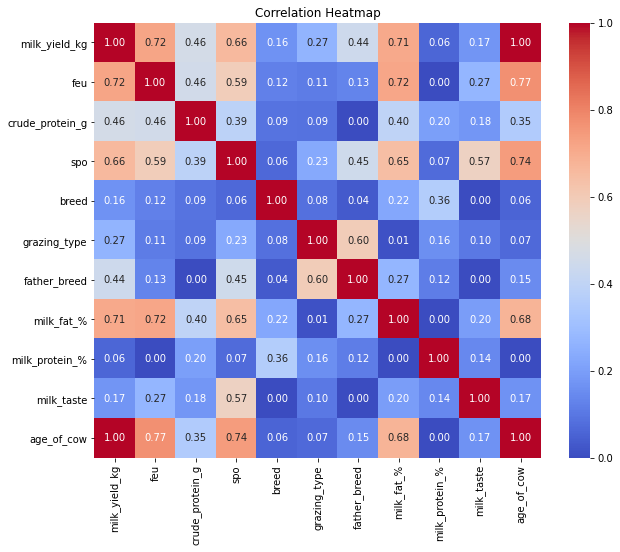

In [48]:
# Создание тепловой карты для матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [49]:
# Преобразование признака feu в квадрат
# fm_df_without_id['feu_squared'] = fm_df_without_id['feu'] ** 2
fm_df['feu_squared'] = fm_df['feu'] ** 2

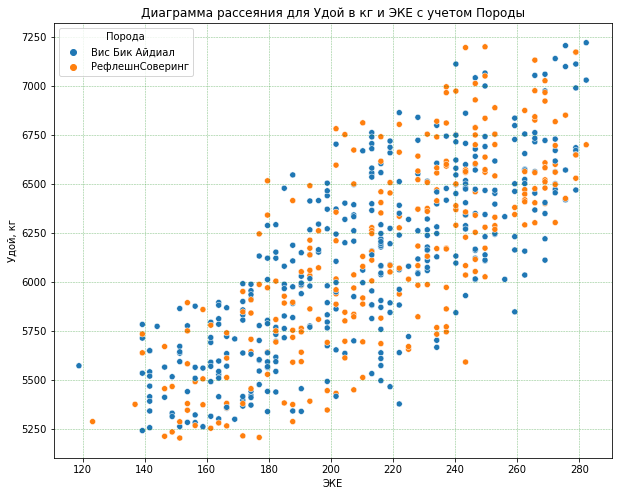

In [50]:
# Указываем размер графика
plt.figure(figsize=(10, 8))
# Построение диаграмм рассеяния с учетом категориальных признаков
sns.scatterplot(x='feu_squared', y='milk_yield_kg', hue='breed', data=fm_df)
plt.title('Диаграмма рассеяния для Удой в кг и ЭКЕ с учетом Породы')
plt.xlabel('ЭКЕ')
plt.ylabel('Удой, кг')
plt.legend(title='Порода')
plt.grid(True, color='g', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [51]:
fm_df['spo_category'] = np.where((fm_df['spo'] >= 0.91) & \
                                            (fm_df['spo'] <= 0.93), 'High', 'Low')

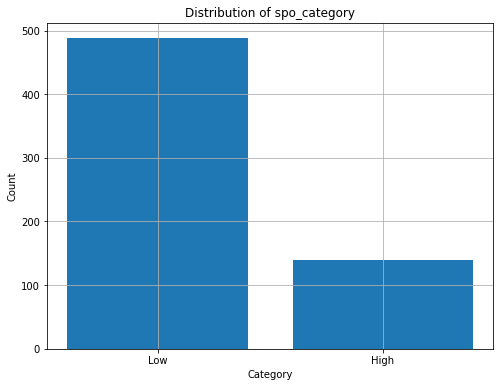

In [52]:
# Подсчет количества значений в каждой категории
# category_counts = fm_df_without_id['spo_category'].value_counts()
category_counts = fm_df['spo_category'].value_counts()


# Построение столбчатой диаграммы
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of spo_category')
plt.grid(True)
plt.show()


In [53]:
# fm_df_without_id.info()
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               628 non-null    int64  
 1   milk_yield_kg    628 non-null    int64  
 2   feu              628 non-null    float64
 3   crude_protein_g  628 non-null    int64  
 4   spo              628 non-null    float64
 5   breed            628 non-null    object 
 6   grazing_type     628 non-null    object 
 7   father_breed     628 non-null    object 
 8   milk_fat_%       628 non-null    float64
 9   milk_protein_%   628 non-null    float64
 10  milk_taste       628 non-null    object 
 11  age_of_cow       628 non-null    object 
 12  feu_squared      628 non-null    float64
 13  spo_category     628 non-null    object 
dtypes: float64(5), int64(3), object(6)
memory usage: 73.6+ KB


In [54]:
# fm_df_without_id['milk_fat_%'].head()
fm_df['milk_fat_%'].head()

0    3.58
1    3.54
2    3.59
3    3.40
4    3.73
Name: milk_fat_%, dtype: float64

In [55]:
fm_df['milk_fat_category'] = np.where(fm_df['milk_fat_%'] <= 3.5, 0,
                                                  np.where(fm_df['milk_fat_%'] <= 3.7, 1, 2))

# Вывод результатов
display(fm_df[['milk_fat_%', 'milk_fat_category']].head())


,milk_fat_%,milk_fat_category
0,3.58,1
1,3.54,1
2,3.59,1
3,3.40,0
4,3.73,2


In [56]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 628 non-null    int64  
 1   milk_yield_kg      628 non-null    int64  
 2   feu                628 non-null    float64
 3   crude_protein_g    628 non-null    int64  
 4   spo                628 non-null    float64
 5   breed              628 non-null    object 
 6   grazing_type       628 non-null    object 
 7   father_breed       628 non-null    object 
 8   milk_fat_%         628 non-null    float64
 9   milk_protein_%     628 non-null    float64
 10  milk_taste         628 non-null    object 
 11  age_of_cow         628 non-null    object 
 12  feu_squared        628 non-null    float64
 13  spo_category       628 non-null    object 
 14  milk_fat_category  628 non-null    int64  
dtypes: float64(5), int64(4), object(6)
memory usage: 78.5+ KB


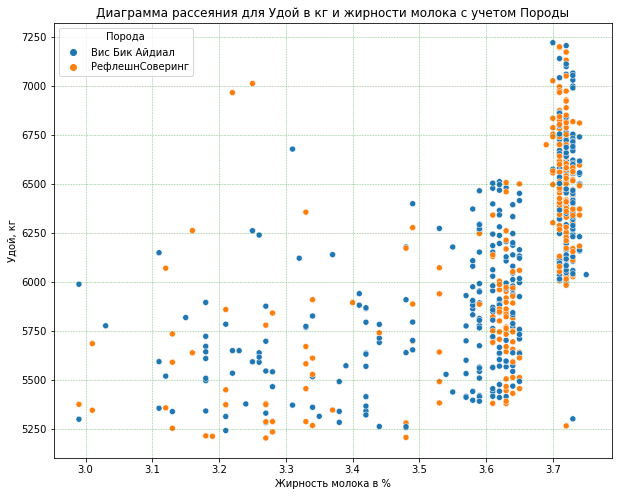

In [57]:
plt.figure(figsize=(10, 8))
# Построение диаграмм рассеяния с учетом категориальных признаков
sns.scatterplot(x='milk_fat_%', y='milk_yield_kg', hue='breed', data=fm_df)
plt.title('Диаграмма рассеяния для Удой в кг и жирности молока с учетом Породы')
plt.xlabel('Жирность молока в %')
plt.ylabel('Удой, кг')
plt.legend(title='Порода')
plt.grid(True, color='g', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

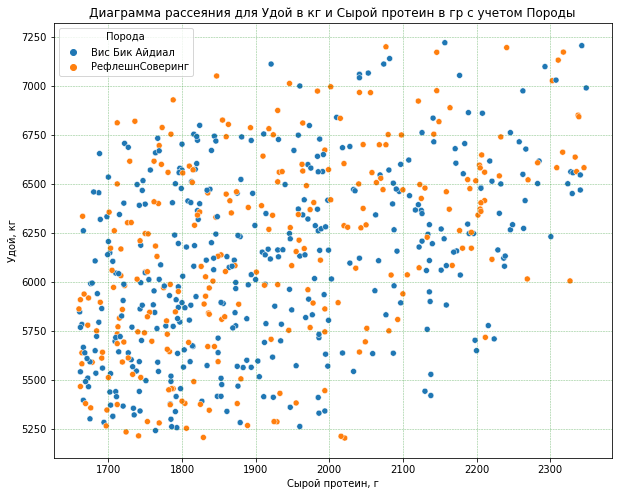

In [58]:
# Указываем размер графика
plt.figure(figsize=(10, 8))
# Построение диаграмм рассеяния с учетом категориальных признаков
sns.scatterplot(x='crude_protein_g', y='milk_yield_kg', hue='breed', data=fm_df)
plt.title('Диаграмма рассеяния для Удой в кг и Сырой протеин в гр с учетом Породы')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Удой, кг')
plt.legend(title='Порода')
plt.grid(True, color='g', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

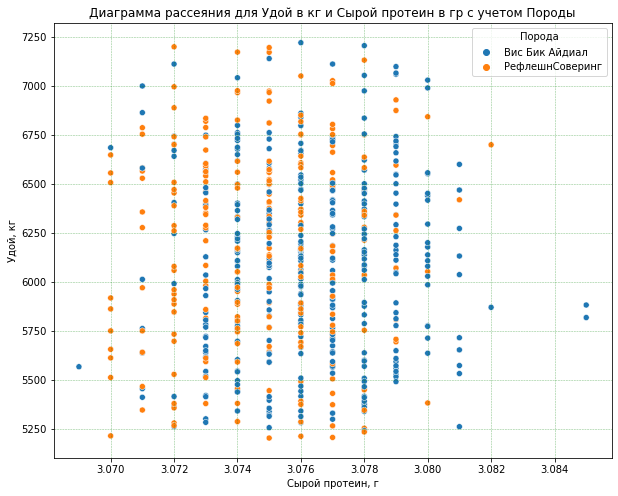

In [59]:
# Указываем размер графика
plt.figure(figsize=(10, 8))
# Построение диаграмм рассеяния с учетом категориальных признаков
sns.scatterplot(x='milk_protein_%', y='milk_yield_kg', hue='breed', data=fm_df)
plt.title('Диаграмма рассеяния для Удой в кг и Сырой протеин в гр с учетом Породы')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Удой, кг')
plt.legend(title='Порода')
plt.grid(True, color='g', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

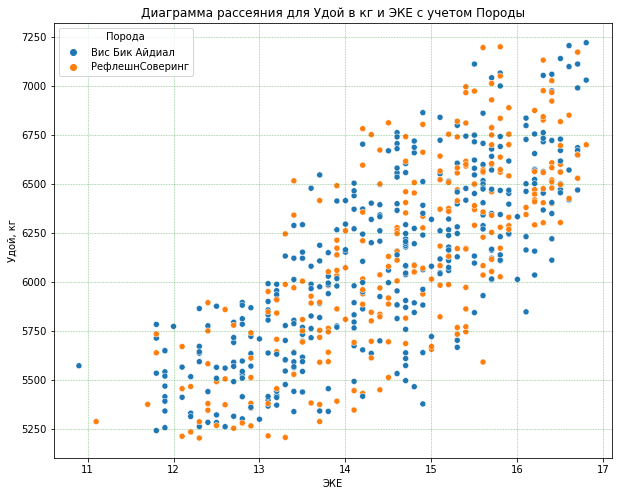

In [60]:
# Указываем размер графика
plt.figure(figsize=(10, 8))
# Построение диаграмм рассеяния с учетом категориальных признаков
sns.scatterplot(x='feu', y='milk_yield_kg', hue='breed', data=fm_df)
plt.title('Диаграмма рассеяния для Удой в кг и ЭКЕ с учетом Породы')
plt.xlabel('ЭКЕ')
plt.ylabel('Удой, кг')
plt.legend(title='Порода')
plt.grid(True, color='g', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

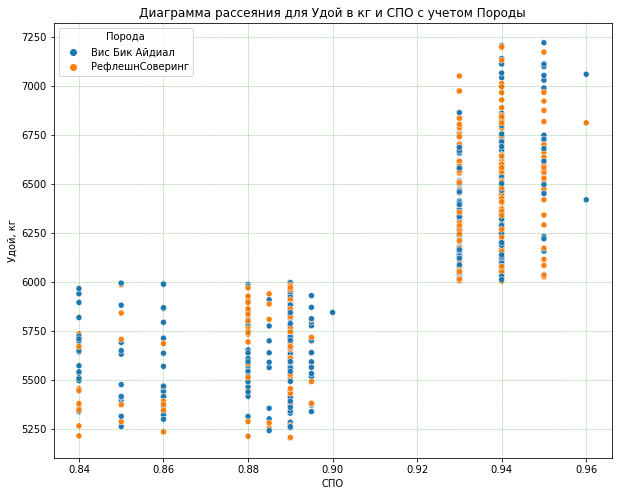

In [61]:
# Указываем размер графика
plt.figure(figsize=(10, 8))
# Построение диаграмм рассеяния с учетом категориальных признаков
sns.scatterplot(x='spo', y='milk_yield_kg', hue='breed', data=fm_df)
plt.title('Диаграмма рассеяния для Удой в кг и СПО с учетом Породы')
plt.xlabel('СПО')
plt.ylabel('Удой, кг')
plt.legend(title='Порода')
plt.grid(True, color='g', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

## Обучение модели линейной регрессии

In [62]:
fm_df['spo_category_binary'] = fm_df['spo_category'].map({'Low': 0, 'High': 1})

In [63]:
fm_df_clean = fm_df.drop(columns=['feu_squared', 'spo_category', 'spo_category_binary'])

In [64]:
RANDOM_STATE = 42

features = ['feu', 'crude_protein_g', 'spo', 'breed', 'grazing_type', 'father_breed', 'age_of_cow']

X = fm_df_clean[features]
y = fm_df_clean['milk_yield_kg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

categorical_features = ['breed', 'grazing_type', 'father_breed', 'age_of_cow']

numerical_features = ['crude_protein_g', 'feu', 'spo']

# Создание преобразователя для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', StandardScaler(), numerical_features),
        ('categorical_features', OneHotEncoder(drop='first'), categorical_features)])

# Обучаем преобразователь и масштабируем тренировочную выборку
X_train_transformed = preprocessor.fit_transform(X_train)

# масштабируем тестовую выборку
X_test_transformed = preprocessor.transform(X_test)

# Создаем экземпляр модели линейной регрессии
model_lr = LinearRegression()

# Обучаем модель на преобразованных тренировочных данных
model_lr.fit(X_train_transformed, y_train)

# Получаем прогнозы на тестовой выборке
y_pred_1 = model_lr.predict(X_test_transformed)

# Рассчитываем R2 score
r2_1 = r2_score(y_test, y_pred_1)

print("R2 =", r2_1)

R2 = 0.8120056410647156


In [65]:
residuals_m1 = y_test - y_pred_1

residuals_m1.describe()

count    126.000000
mean     -25.130847
std      196.729165
min     -530.652820
25%     -165.917462
50%      -35.063273
75%       84.792322
max      489.044351
Name: milk_yield_kg, dtype: float64

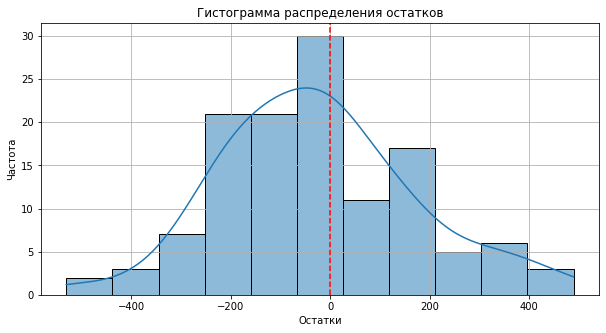

In [66]:
# Гистограмма распределения остатков
plt.figure(figsize=(10, 5))
# plt.histplot(residuals_m1, bins=50)
sns.histplot(residuals_m1, kde=True)
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

По гистограмме распределения остатков первой модели МО, видно что распределение нормальное с отклонением в левую сторону 

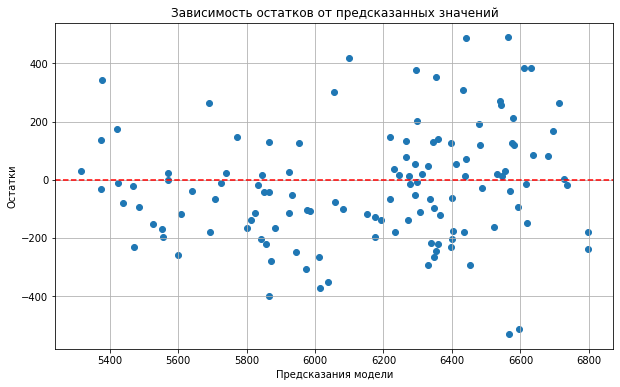

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_1, residuals_m1)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Зависимость остатков от предсказанных значений')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

По `scatter` графику зависимости остатков от предсказанных значений первой модели МО, видно что значений больше в отрицательную сторону от 0

In [68]:
# Создание нового признака - ЭКЕ в квадрате
fm_df_clean[['feu_squared']] = fm_df[['feu_squared']]

fm_df_clean['spo_category_binary'] = (fm_df_clean['spo'] > 0.91).astype(int)

# Обновление списка признаков для модели
features_m2 = features.copy()
features_m2.remove('spo')
# features_m2.remove('feu')             
features_m2.append('spo_category_binary')
features_m2.append('feu_squared')
features_m2

['feu',
 'crude_protein_g',
 'breed',
 'grazing_type',
 'father_breed',
 'age_of_cow',
 'spo_category_binary',
 'feu_squared']

In [69]:
features_m2

['feu',
 'crude_protein_g',
 'breed',
 'grazing_type',
 'father_breed',
 'age_of_cow',
 'spo_category_binary',
 'feu_squared']

In [70]:
# Подготавливаем данные ко второй модели
X_m2 = fm_df_clean[features_m2]
y_m2 = fm_df_clean['milk_yield_kg']

X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_m2, y_m2, test_size=0.2, random_state=RANDOM_STATE)

categorical_features_m2 = ['breed', 'grazing_type', 'father_breed', 'age_of_cow']

numerical_features_m2 = ['crude_protein_g', 'feu_squared', 'spo_category_binary']


# Создание преобразователя для числовых и категориальных признаков
preprocessor_m2 = ColumnTransformer(
    transformers=[
        ('numerical_features', StandardScaler(), numerical_features_m2),
        ('categorical_features', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_m2)])

# Обучаем преобразователь и масштабируем тренировочную выборку
X_train_transformed_m2 = preprocessor_m2.fit_transform(X_train_m2)

# масштабируем тестовую выборку
X_test_transformed_m2 = preprocessor_m2.transform(X_test_m2)

# Создаем экземпляр модели линейной регрессии
model_lr_2 = LinearRegression()

# Обучаем модель на преобразованных тренировочных данных
model_lr_2.fit(X_train_transformed_m2, y_train_m2)

# Получаем прогнозы на тестовой выборке
y_pred_2 = model_lr_2.predict(X_test_transformed_m2)

# Рассчитываем R2 score
r2_2 = r2_score(y_test_m2, y_pred_2)

print("R2 =", r2_2)

R2 = 0.8270982461105694


In [71]:
residuals_m2 = y_test_m2 - y_pred_2

display(residuals_m1.describe())
residuals_m2.describe()

count    126.000000
mean     -25.130847
std      196.729165
min     -530.652820
25%     -165.917462
50%      -35.063273
75%       84.792322
max      489.044351
Name: milk_yield_kg, dtype: float64

count    126.000000
mean     -24.598030
std      188.602366
min     -597.050535
25%     -157.492194
50%      -27.974956
75%       66.886431
max      469.851281
Name: milk_yield_kg, dtype: float64

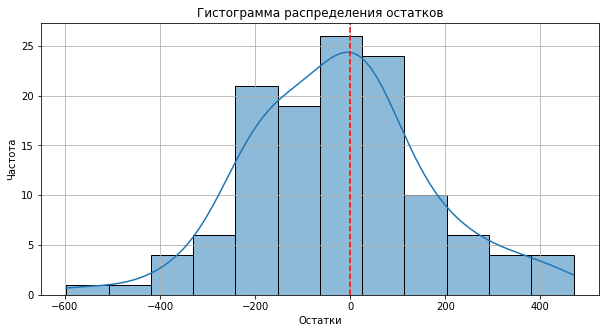

In [72]:
# Гистограмма распределения остатков
plt.figure(figsize=(10, 5))
# plt.histplot(residuals_m1, bins=50)
sns.histplot(residuals_m2, kde=True)
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

По гистограмме распределения остатков второй модели МО, видно что распределение нормальное с отклонением в левую сторону 

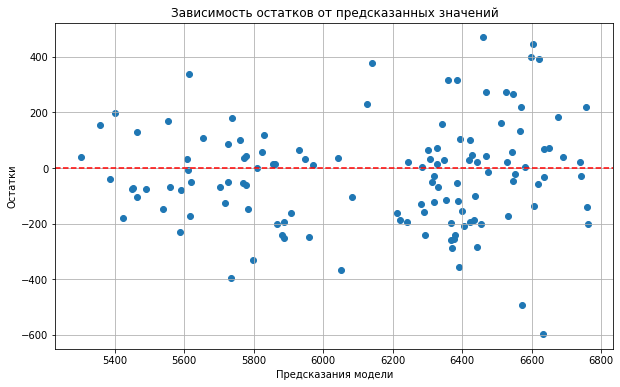

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_2, residuals_m2)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Зависимость остатков от предсказанных значений')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

По гистограмме распределения остатков второй модели МО, видно что распределение нормальное с отклонением в левую сторону 

По `scatter` графику зависимости остатков от предсказанных значений второй модели МО, видно что значений больше в отрицательную сторону от 0

In [74]:
missing_ids_in_df2 = fm_df[~fm_df['id'].isin(dad_df['id'])]['id'].tolist()
display(missing_ids_in_df2)

missing_ids_in_df1 = dad_df[~dad_df['id'].isin(fm_df['id'])]['id'].tolist()
display(missing_ids_in_df1)

[]

[17]

Проверяем строки, которые есть между двумя датафреймами и выводим значение `id` таких строк

In [75]:
display(dad_df[dad_df['id'] == 17])

,id,father_name
16,17,Буйный


Удаляем из датафрейма `dad_df` строку с `id` равной `17`

In [76]:
dad_df_id_17_to_drop = dad_df[dad_df['id'] == 17].index

dad_df = dad_df.drop(dad_df_id_17_to_drop)
display(dad_df.nunique())

id             628
father_name      4
dtype: int64

In [77]:
# Создаем новый датафрейм с помощью метода merge из двух датафреймов
fm_dad_merged = pd.merge(fm_df_clean, dad_df, on='id', how='left')
fm_dad_merged.head()

fm_dad_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    int64  
 1   milk_yield_kg        628 non-null    int64  
 2   feu                  628 non-null    float64
 3   crude_protein_g      628 non-null    int64  
 4   spo                  628 non-null    float64
 5   breed                628 non-null    object 
 6   grazing_type         628 non-null    object 
 7   father_breed         628 non-null    object 
 8   milk_fat_%           628 non-null    float64
 9   milk_protein_%       628 non-null    float64
 10  milk_taste           628 non-null    object 
 11  age_of_cow           628 non-null    object 
 12  milk_fat_category    628 non-null    int64  
 13  feu_squared          628 non-null    float64
 14  spo_category_binary  628 non-null    int64  
 15  father_name          628 non-null    obj

Обучаем модель с новыми признаками

In [78]:
features_m3 = ['feu_squared', 'crude_protein_g', 'spo', 'breed', 'grazing_type', 'father_breed', 'age_of_cow']

X_m3 = fm_dad_merged[features_m3]
y_m3 = fm_dad_merged['milk_yield_kg']

X_train_m3, X_test_m3, y_train_m3, y_test_m3 = train_test_split(X_m3, y_m3, test_size=0.2, random_state=42)


categorical_features_m3 = ['breed', 'grazing_type', 'father_breed', 'age_of_cow']

numerical_features_m3 = ['crude_protein_g', 'feu_squared', 'spo']


# Создание преобразователя для числовых и категориальных признаков
preprocessor_m3 = ColumnTransformer(
    transformers=[
        ('numerical_features', StandardScaler(), numerical_features_m3),
        ('categorical_features', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_m3)])

# Обучаем преобразователь и масштабируем тренировочную выборку
X_train_transformed_m3 = preprocessor_m3.fit_transform(X_train_m3)

# масштабируем тестовую выборку
X_test_transformed_m3 = preprocessor_m3.transform(X_test_m3)

# Создаем экземпляр модели линейной регрессии
model_lr_3 = LinearRegression()

# Обучаем модель на преобразованных тренировочных данных
model_lr_3.fit(X_train_transformed_m3, y_train_m3)

# Получаем прогнозы на тестовой выборке
y_pred_3 = model_lr_3.predict(X_test_transformed_m3)

# Рассчитываем R2 score
r2_3 = r2_score(y_test_m3, y_pred_3)

print("R2 =", r2_3)

R2 = 0.8127426534637494


In [79]:
residuals_m3 = y_test_m3 - y_pred_3

residuals_m3.describe()

count    126.000000
mean     -24.939297
std      196.361421
min     -539.038706
25%     -166.261070
50%      -34.947502
75%       80.707009
max      486.790310
Name: milk_yield_kg, dtype: float64

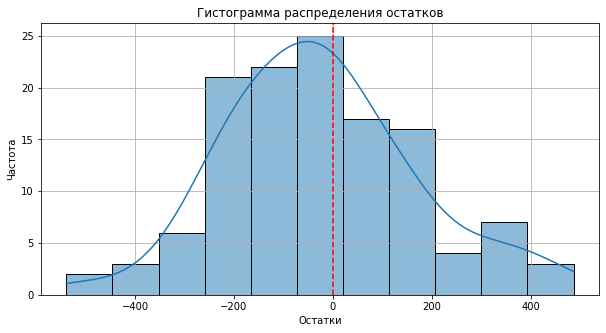

In [80]:
# Гистограмма распределения остатков
plt.figure(figsize=(10, 5))
# plt.histplot(residuals_m1, bins=50)
sns.histplot(residuals_m3, kde=True)
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

По гистограмме распределения остатков третьей модели МО, видно что распределение нормальное с отклонением в левую сторону 

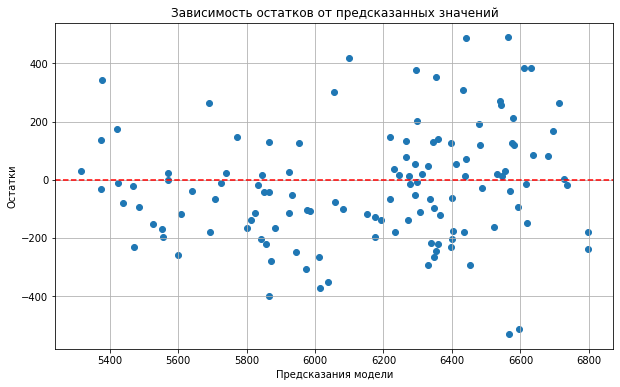

In [81]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_1, residuals_m1)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Зависимость остатков от предсказанных значений')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

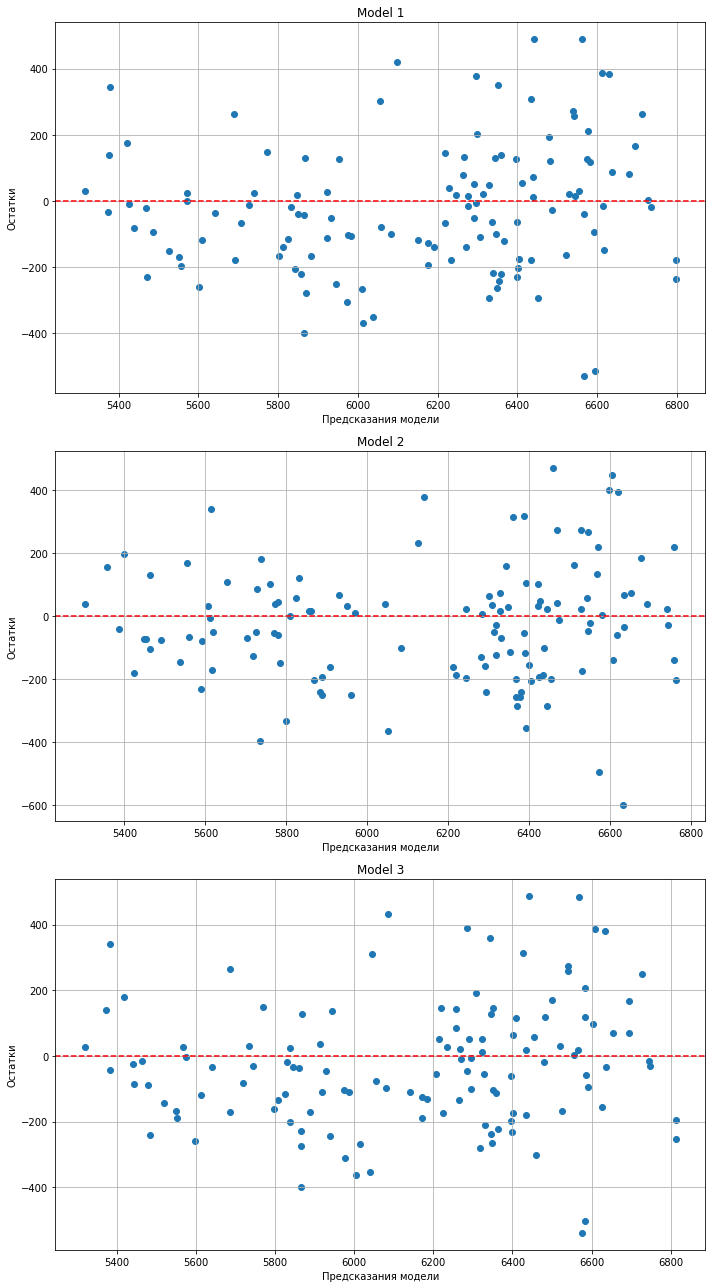

In [82]:
# Создаем фигуру и оси для каждого графика
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Задаем заголовок для каждого графика
titles = ['Model 1', 'Model 2', 'Model 3']

# Создаем список предсказаний и остатков для каждой модели
predictions_list = [y_pred_1, y_pred_2, y_pred_3]
residuals_list = [residuals_m1, residuals_m2, residuals_m3]

# Перебираем модели и создаем графики
for i, (predictions, residuals) in enumerate(zip(predictions_list, residuals_list)):
    ax = axes[i]
    ax.scatter(predictions, residuals)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Предсказания модели')
    ax.set_ylabel('Остатки')
    ax.set_title(titles[i])
    ax.grid(True)

# Регулируем расположение графиков на фигуре
plt.tight_layout()

# Отображаем графики
plt.show()


In [83]:
display(residuals_m1.describe())
display(residuals_m2.describe())
residuals_m3.describe()

count    126.000000
mean     -25.130847
std      196.729165
min     -530.652820
25%     -165.917462
50%      -35.063273
75%       84.792322
max      489.044351
Name: milk_yield_kg, dtype: float64

count    126.000000
mean     -24.598030
std      188.602366
min     -597.050535
25%     -157.492194
50%      -27.974956
75%       66.886431
max      469.851281
Name: milk_yield_kg, dtype: float64

count    126.000000
mean     -24.939297
std      196.361421
min     -539.038706
25%     -166.261070
50%      -34.947502
75%       80.707009
max      486.790310
Name: milk_yield_kg, dtype: float64

In [84]:
mae_m1 = mean_absolute_error(y_test, y_pred_1)
mse_m1 = mean_squared_error(y_test, y_pred_1)
rmse_m1 = np.sqrt(mse_m1)

print("mae: ", mae_m1)
print("mse: ", mse_m1)
print("rmse: ", rmse_m1)

mae:  155.13314412297413
mse:  39026.76237180601
rmse:  197.55192322983345


In [85]:
mae_m2 = mean_absolute_error(y_test_m2, y_pred_2)
mse_m2 = mean_squared_error(y_test_m2, y_pred_2)
rmse_m2 = np.sqrt(mse_m2)

print("mae: ", mae_m2)
print("mse: ", mse_m2)
print("rmse: ", rmse_m2)

mae:  146.63761680653613
mse:  35893.607132297926
rmse:  189.45608233123033


In [86]:
mae_m3 = mean_absolute_error(y_test_m3, y_pred_3)
mse_m3 = mean_squared_error(y_test_m3, y_pred_3)
rmse_m3 = np.sqrt(mse_m3)

print("mae: ", mae_m3)
print("mse: ", mse_m3)
print("rmse: ", rmse_m3)

mae:  154.9094279961257
mse:  38873.76199495926
rmse:  197.16430202995485


In [87]:
print("Model №1: ", r2_1)
print("Model №2: ", r2_2)
print("Model №3: ", r2_3)


Model №1:  0.8120056410647156
Model №2:  0.8270982461105694
Model №3:  0.8127426534637494


In [88]:
print('95% доверительный интервал =', st.norm.interval(confidence=0.95, loc=np.mean(y_pred_2), scale=st.sem(y_pred_2)))

95% доверительный интервал = (6081.126054992589, 6222.30809931151)


In [89]:
features_m2.remove('feu')
features_m2

['crude_protein_g',
 'breed',
 'grazing_type',
 'father_breed',
 'age_of_cow',
 'spo_category_binary',
 'feu_squared']

In [90]:
mean_fm_df_values = fm_df_clean[['crude_protein_g', 'feu_squared', 'spo_category_binary', 'milk_yield_kg']].mean()

cow_df['feu_squared'] = mean_fm_df_values['feu_squared'] * 1.05
cow_df['crude_protein_g'] = mean_fm_df_values['crude_protein_g'] * 1.05
cow_df['spo_category_binary'] = mean_fm_df_values['spo_category_binary'] * 1.05

In [91]:
cow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cow_breed            20 non-null     object 
 1   grazing_type         20 non-null     object 
 2   father_breed         20 non-null     object 
 3   father_name          20 non-null     object 
 4   curr_milk_fat_%      20 non-null     float64
 5   curr_protein_%       20 non-null     float64
 6   age_of_cow           20 non-null     object 
 7   feu_squared          20 non-null     float64
 8   crude_protein_g      20 non-null     float64
 9   spo_category_binary  20 non-null     float64
dtypes: float64(5), object(5)
memory usage: 1.7+ KB


In [92]:
cow_df = cow_df.rename(columns={'cow_breed': 'breed'})

In [93]:
cow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   grazing_type         20 non-null     object 
 2   father_breed         20 non-null     object 
 3   father_name          20 non-null     object 
 4   curr_milk_fat_%      20 non-null     float64
 5   curr_protein_%       20 non-null     float64
 6   age_of_cow           20 non-null     object 
 7   feu_squared          20 non-null     float64
 8   crude_protein_g      20 non-null     float64
 9   spo_category_binary  20 non-null     float64
dtypes: float64(5), object(5)
memory usage: 1.7+ KB


In [94]:
features_m2

['crude_protein_g',
 'breed',
 'grazing_type',
 'father_breed',
 'age_of_cow',
 'spo_category_binary',
 'feu_squared']

In [95]:
X_cow_buy_transformed = preprocessor_m2.transform(cow_df[features_m2])

y_pred_cow_buy = model_lr_2.predict(X_cow_buy_transformed)

print(y_pred_cow_buy)

[6359.09610186 5914.06123183 6127.35064744 6365.31047283 6365.31047283
 5920.27560281 6359.09610186 6121.13627646 6127.35064744 6158.23542821
 6121.13627646 6127.35064744 6359.09610186 5914.06123183 6127.35064744
 6365.31047283 6121.13627646 5920.27560281 6121.13627646 6365.31047283]


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [96]:
for i, prediction in enumerate(y_pred_cow_buy):
    print(f"Предсказанное значение для коровы с индексом {i}:  {prediction}")

Предсказанное значение для коровы с индексом 0:  6359.096101857095
Предсказанное значение для коровы с индексом 1:  5914.061231829302
Предсказанное значение для коровы с индексом 2:  6127.350647435568
Предсказанное значение для коровы с индексом 3:  6365.310472834745
Предсказанное значение для коровы с индексом 4:  6365.310472834745
Предсказанное значение для коровы с индексом 5:  5920.2756028069525
Предсказанное значение для коровы с индексом 6:  6359.096101857095
Предсказанное значение для коровы с индексом 7:  6121.136276457918
Предсказанное значение для коровы с индексом 8:  6127.350647435568
Предсказанное значение для коровы с индексом 9:  6158.235428206129
Предсказанное значение для коровы с индексом 10:  6121.136276457918
Предсказанное значение для коровы с индексом 11:  6127.350647435568
Предсказанное значение для коровы с индексом 12:  6359.096101857095
Предсказанное значение для коровы с индексом 13:  5914.061231829302
Предсказанное значение для коровы с индексом 14:  6127.35

## Обучение модели логистической регрессии

In [97]:
# Получаем новый датафрейм для новой модели
fm_df_2 = fm_df_clean.copy()

In [98]:
# Задаем признаки 
y_4 = fm_df_2['milk_taste'].map({'не вкусно': 0, 'вкусно': 1})

features_4 = fm_df_2.columns.drop('milk_taste')

In [99]:
features_4 = features_4.drop('id')
features_4 = features_4.drop('milk_yield_kg')
features_4

Index(['feu', 'crude_protein_g', 'spo', 'breed', 'grazing_type',
       'father_breed', 'milk_fat_%', 'milk_protein_%', 'age_of_cow',
       'milk_fat_category', 'feu_squared', 'spo_category_binary'],
      dtype='object')

In [100]:
# Меняем названия столбцов датафрейма cow_df
new_column_names = {
    'curr_milk_fat_%': 'milk_fat_%',
    'curr_protein_%': 'milk_protein_%'
}

# Используем метод rename для изменения имен столбцов
cow_df = cow_df.rename(columns=new_column_names)

In [101]:
cow_df['milk_fat_category'] = np.where(cow_df['milk_fat_%'] <= 3.5, 0,
                                                  np.where(cow_df['milk_fat_%'] <= 3.7, 1, 2))

In [102]:
cow_df.head()

,breed,grazing_type,father_breed,father_name,milk_fat_%,milk_protein_%,age_of_cow,feu_squared,crude_protein_g,spo_category_binary,milk_fat_category
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,224.025225,2019.947532,0.618631,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,224.025225,2019.947532,0.618631,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,224.025225,2019.947532,0.618631,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,224.025225,2019.947532,0.618631,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,224.025225,2019.947532,0.618631,1


In [103]:
X_4 = fm_df_2[features_4]

# Создаем словарь, в котором ключами будут типы данных, а значениями - списки столбцов с этим типом данных
column_types = X_4.dtypes.groupby(X_4.dtypes).groups

categorical_features = X_4.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_4.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('spo_category_binary')
categorical_features.append('spo_category_binary')

# Обновленный список категориальных признаков без отсутствующих столбцов
categorical_features_filtered = [col for col in categorical_features if col not in ['feu', 'spo', 'milk_fat_%', 'milk_protein_%']]

# Создаем преобразователь
preprocessor_4 = ColumnTransformer(
    transformers=[
        ('numerical_features', StandardScaler(), numerical_features),
        ('categorical_features', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_filtered)
    ],
    remainder='passthrough'  
)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_4,
    y_4,
    test_size=0.2,
    random_state=42
)
                      
X_train_transformed_4 = preprocessor_4.fit_transform(X_train_4)
X_test_transformed_4 = preprocessor_4.transform(X_test_4)
                      
model_lr_4 = LogisticRegression(max_iter=1000)
model_lr_4.fit(X_train_transformed_4, y_train_4)

y_pred_4 = model_lr_4.predict(X_test_transformed_4) 
                      
accuracy = accuracy_score(y_test_4, y_pred_4)
recall = recall_score(y_test_4, y_pred_4)                  
precision = precision_score(y_test_4, y_pred_4)                

print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)


Accuracy:  0.7063492063492064
Recall:  0.863013698630137
Precision:  0.7


1:

- Accuracy:  0.7301587301587301
- Recall:  0.8767123287671232
- Precision:  0.7191011235955056

2:

- Accuracy:  0.746031746031746
- Recall:  0.8904109589041096
- Precision:  0.7303370786516854

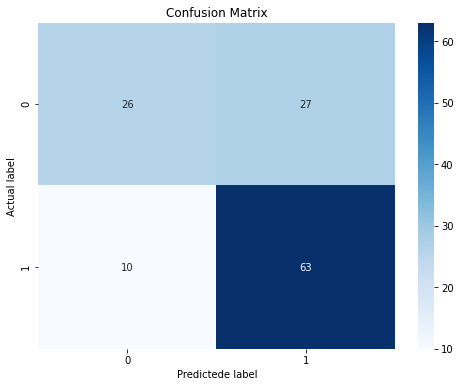

In [104]:
conf_matrix = confusion_matrix(y_test_4, y_pred_4)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predictede label")
plt.show()

- 0 = 29, 24
- 1 = 8, 65

In [105]:
y_scores_4 = model_lr_4.predict_proba(X_test_transformed_4)[:, 1]

precision, recalls, thresholds = precision_recall_curve(y_test_4, y_scores_4)

thresholds_precision_1 = thresholds[np.argmax(precision == 1)]
    
print("Порог, при котором precision равна 1:", thresholds_precision_1)

Порог, при котором precision равна 1: 0.7771167437116692


In [106]:
threshold = thresholds_precision_1 * 1.05
threshold

0.8159725808972527

In [107]:
y_pred_proba_4 = model_lr_4.predict_proba(X_test_transformed_4)
y_pred_new_threshold_4 = (y_pred_proba_4[:, 1] > threshold).astype(int)

new_recall = recall_score(y_test_4, y_pred_new_threshold_4)
new_precision = precision_score(y_test_4, y_pred_new_threshold_4)

print("threshold: ", threshold)
print("Recall: ", new_recall)
print("Precision: ", new_precision)


threshold:  0.8159725808972527
Recall:  0.0821917808219178
Precision:  1.0


0.7911057397603547  (1.0030): 
- Recall:  0.1506849315068493
- Precision:  1.0

In [108]:
fm_df_2['father_breed'].nunique()

3

In [109]:
cow_df['father_breed'].nunique()

2

In [110]:
# Проходим по каждой строке в cow_df
for index, row in cow_df.iterrows():
    # Извлекаем значения breed и father_breed из текущей строки
    breed = row['breed']
    father_breed = row['father_breed']
    
    # Ищем соответствующие строки в fm_df_2
    matching_rows = fm_df_2[(fm_df_2['breed'] == breed) & (fm_df_2['father_breed'] == father_breed)]
    
    # Если найдены соответствующие строки, добавляем значения feu и spo в cow_df_copy
    if not matching_rows.empty:
        feu_value = matching_rows['feu'].iloc[0]
        spo_value = matching_rows['spo'].iloc[0]
        cow_df.loc[index, 'feu'] = feu_value
        cow_df.loc[index, 'spo'] = spo_value

# Выводим информацию о новом датафрейме
print(cow_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   grazing_type         20 non-null     object 
 2   father_breed         20 non-null     object 
 3   father_name          20 non-null     object 
 4   milk_fat_%           20 non-null     float64
 5   milk_protein_%       20 non-null     float64
 6   age_of_cow           20 non-null     object 
 7   feu_squared          20 non-null     float64
 8   crude_protein_g      20 non-null     float64
 9   spo_category_binary  20 non-null     float64
 10  milk_fat_category    20 non-null     int64  
 11  feu                  20 non-null     float64
 12  spo                  20 non-null     float64
dtypes: float64(7), int64(1), object(5)
memory usage: 2.2+ KB
None


In [111]:
# Выводим информацию о новом датафрейме
print(cow_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   grazing_type         20 non-null     object 
 2   father_breed         20 non-null     object 
 3   father_name          20 non-null     object 
 4   milk_fat_%           20 non-null     float64
 5   milk_protein_%       20 non-null     float64
 6   age_of_cow           20 non-null     object 
 7   feu_squared          20 non-null     float64
 8   crude_protein_g      20 non-null     float64
 9   spo_category_binary  20 non-null     float64
 10  milk_fat_category    20 non-null     int64  
 11  feu                  20 non-null     float64
 12  spo                  20 non-null     float64
dtypes: float64(7), int64(1), object(5)
memory usage: 2.2+ KB
None


In [112]:
fm_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    int64  
 1   milk_yield_kg        628 non-null    int64  
 2   feu                  628 non-null    float64
 3   crude_protein_g      628 non-null    int64  
 4   spo                  628 non-null    float64
 5   breed                628 non-null    object 
 6   grazing_type         628 non-null    object 
 7   father_breed         628 non-null    object 
 8   milk_fat_%           628 non-null    float64
 9   milk_protein_%       628 non-null    float64
 10  milk_taste           628 non-null    object 
 11  age_of_cow           628 non-null    object 
 12  milk_fat_category    628 non-null    int64  
 13  feu_squared          628 non-null    float64
 14  spo_category_binary  628 non-null    int64  
dtypes: float64(5), int64(5), object(5)
memor

In [113]:
# Применение тех же преобразований, что и для обучающей выборки
X_cow_transformed = preprocessor_4.transform(cow_df)

# Прогнозирование вероятностей принадлежности к классам
y_cow_pred_proba = model_lr_4.predict_proba(X_cow_transformed)

# Определение порога для классификации
threshold_milk_taste = threshold

# Прогнозирование по вероятностям с применением порога
y_cow_pred = (y_cow_pred_proba[:, 1] > threshold_milk_taste).astype(int)

# Вывод результата прогноза
print("Прогноз вкуса молока коров:")
print(y_cow_pred)


Прогноз вкуса молока коров:
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [114]:
# Создаем датафрейм с предсказанными значениями (колонка taste_predictions)
predictions_df = pd.DataFrame({'taste_predictions': y_cow_pred}, index=cow_df.index)

# Объединяем предсказанные значения с исходным датафреймом
cow_with_predictions_df = pd.concat([cow_df, predictions_df], axis=1)

# Добавляем столбец 'Taste' на основе вероятностей в колонке 'taste_predictions'
cow_with_predictions_df['taste_pred'] = cow_with_predictions_df['taste_predictions'].apply(lambda x: 'вкусно' if x > 0.5 else 'не вкусно')

# Выводим строки, где предсказанные значения равны 1 (вероятность вкусного молока больше 0.5)
predicted_as_tasty = cow_with_predictions_df[cow_with_predictions_df['taste_pred'] == 'вкусно']
display(predicted_as_tasty)


,breed,grazing_type,father_breed,father_name,milk_fat_%,milk_protein_%,age_of_cow,feu_squared,crude_protein_g,spo_category_binary,milk_fat_category,feu,spo,taste_predictions,taste_pred
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,224.025225,2019.947532,0.618631,1,12.8,0.89,1,вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,224.025225,2019.947532,0.618631,1,12.8,0.89,1,вкусно
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,224.025225,2019.947532,0.618631,2,12.8,0.89,1,вкусно


Эти прогнозы модели МО, могут помочь фермеру при принятии решения о покупке коров, основываясь на предполагаемом качестве молока.

In [115]:
# Создаем датафрейм с предсказанными значениями
predictions_df = pd.DataFrame({'6000_predictions': y_pred_cow_buy}, index=cow_df.index)

# Объединяем предсказанные значения с исходным датафреймом
cow_with_predictions_df = pd.concat([cow_df, predictions_df], axis=1)

# Выводим строки, где предсказанные значения больше 6000
predicted_above_6000 = cow_with_predictions_df[cow_with_predictions_df['6000_predictions'] > 6000]
display(predicted_above_6000)


,breed,grazing_type,father_breed,father_name,milk_fat_%,milk_protein_%,age_of_cow,feu_squared,crude_protein_g,spo_category_binary,milk_fat_category,feu,spo,6000_predictions
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,224.025225,2019.947532,0.618631,1,14.2,0.890,6359.096102
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,224.025225,2019.947532,0.618631,1,14.0,0.885,6127.350647
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,224.025225,2019.947532,0.618631,0,12.4,0.885,6365.310473
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,224.025225,2019.947532,0.618631,1,12.4,0.885,6365.310473
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,224.025225,2019.947532,0.618631,1,14.2,0.890,6359.096102
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,224.025225,2019.947532,0.618631,1,12.8,0.890,6121.136276
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,224.025225,2019.947532,0.618631,1,14.0,0.885,6127.350647
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,224.025225,2019.947532,0.618631,0,12.4,0.885,6158.235428
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,224.025225,2019.947532,0.618631,2,12.8,0.890,6121.136276
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,224.025225,2019.947532,0.618631,2,14.0,0.885,6127.350647


## Итоговые выводы

In [116]:
try:
    cow_df['taste_predictions'] = predicted_as_tasty
    cow_df['6000_predictions'] = predicted_above_6000
    
except ValueError:
    pass
cow_df.head()

,breed,grazing_type,father_breed,father_name,milk_fat_%,milk_protein_%,age_of_cow,feu_squared,crude_protein_g,spo_category_binary,milk_fat_category,feu,spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,224.025225,2019.947532,0.618631,1,14.2,0.890
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,224.025225,2019.947532,0.618631,1,12.8,0.890
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,224.025225,2019.947532,0.618631,1,14.0,0.885
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,224.025225,2019.947532,0.618631,0,12.4,0.885
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,224.025225,2019.947532,0.618631,1,12.4,0.885


**Вывод:**

4 коровы фермер может купить из стада на продажу с минимальным риском для себя, так как при покупке такого количество коров, фермер сможет выполнить свой план развития молочного хозяйства.

**Выводы о моделях линейной и логистической регрессиий:**

В модели линейной регрессии лучше использовались такие подходы, как удаление выборосов и преобразовнаие признаков. Дальнейшее улучшение может включать анализ корреляций между признаками и целевой переменной. В модели логистической регерессии можно изменять порог классификации для улучшения полноты метрики recall в ущерб точности метрики precision. Для метрик моделей классификации важными метриками являются accuracy, recall и precision. При анализе рисков или экономических расчетов особенно важны метрики recall и precision для минимализации риска.